<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_CVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multi Sensor Fusion Crash Detection - Computer Vision Model**

##**Setup and Load Data**

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#dataset path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v4-transitlk_msfcd_cvm_v4.folder'

print(f"\nDataset path: {BASE_PATH}")

TensorFlow Version: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset path: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v4-transitlk_msfcd_cvm_v4.folder


##**Exploratory Data Analysis**

Exploratory Data Analysis

Dataset structure found:
  train: Crash=820, Normal=685, Total=1505
  test: Crash=42, Normal=36, Total=78
  valid: Crash=86, Normal=73, Total=159

Dataset loaded: 1742 images
   split  label                                         filename
0  train  crash  008_png.rf.6309c4523928718d30e82e6cb1442fce.jpg
1  train  crash  005_png.rf.f8a83a1e12bcfb92ee7e0051390f21e4.jpg
2  train  crash  015_png.rf.32b11e4b23af221ccf7570e3833f1865.jpg
3  train  crash  007_png.rf.2035e1a5cdd6244e50d44de575d11622.jpg
4  train  crash  004_png.rf.f7d6a182be50fa51649d04f8257fa0bd.jpg

1. Class Distribution (Crash vs Normal):
label
crash     948
normal    794
Name: count, dtype: int64

Crash rate: 54.42%


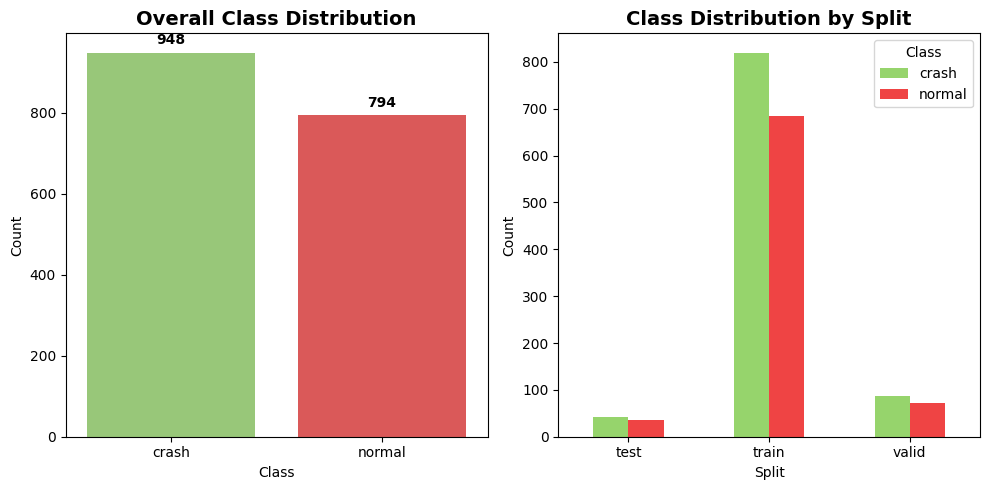


2. Sample Images:


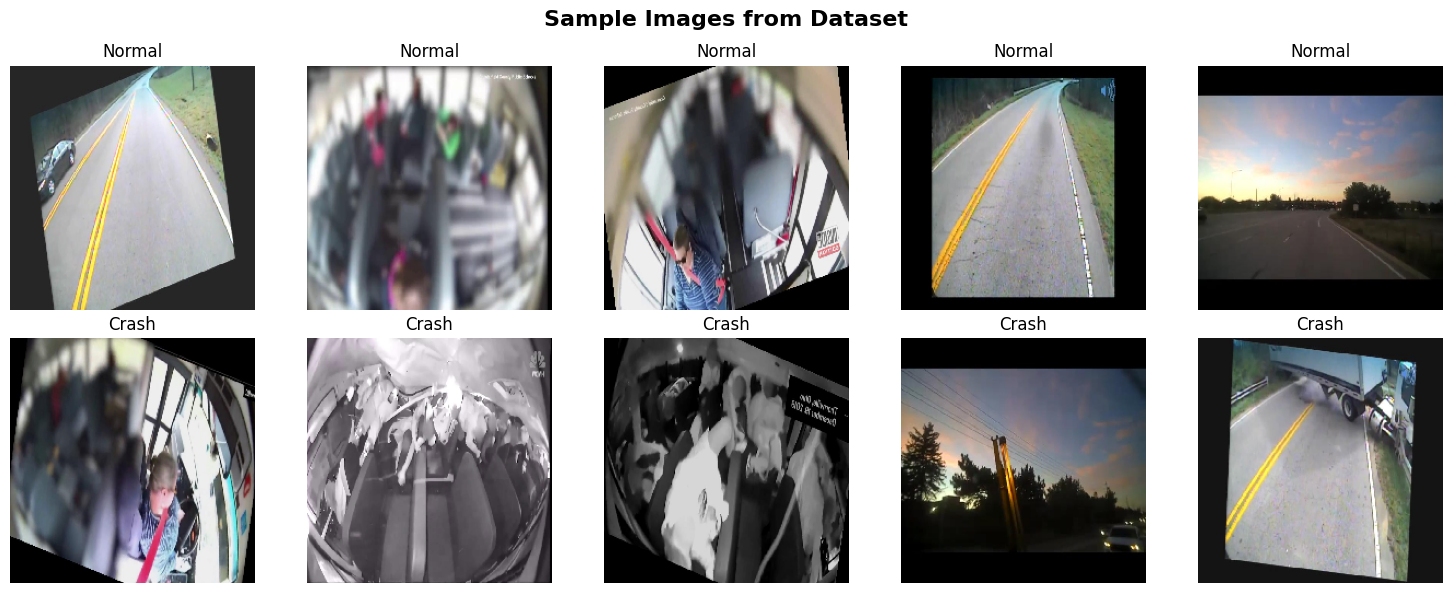

In [25]:
print("Exploratory Data Analysis\n")

#check if path exists and list structure
import os
if os.path.exists(BASE_PATH):
    print("Dataset structure found:")
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(BASE_PATH, split)
        if os.path.exists(split_path):
            crash_dir = os.path.join(split_path, 'crash')
            normal_dir = os.path.join(split_path, 'normal')
            crash_count = len([f for f in os.listdir(crash_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(crash_dir) else 0
            normal_count = len([f for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(normal_dir) else 0
            print(f"  {split}: Crash={crash_count}, Normal={normal_count}, Total={crash_count + normal_count}")
else:
    print("Path not found! Please check your dataset location.")

#create dataframe for analysis
data = []
for split in ['train', 'test', 'valid']:
    for label in ['crash', 'normal']:
        folder = os.path.join(BASE_PATH, split, label)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:
                data.append({'split': split, 'label': label, 'filename': f})

df = pd.DataFrame(data)
print(f"\nDataset loaded: {len(df)} images")
print(df.head())

#class distribution analysis
print("\n1. Class Distribution (Crash vs Normal):")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nCrash rate: {class_counts.get('crash', 0)/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

#distribution by split
plt.subplot(1, 2, 2)
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=plt.gca(), color=['#96d46c', '#ef4444'])
plt.title('Class Distribution by Split', fontsize=14, fontweight='bold')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#show sample images
print("\n2. Sample Images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for idx, label in enumerate(['normal', 'crash']):
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        sample_files = label_df.sample(min(5, len(label_df)))['filename'].values
        for i, filename in enumerate(sample_files):
            #get full path (assuming from train split for samples)
            img_path = os.path.join(BASE_PATH, 'train', label, filename)
            if not os.path.exists(img_path):
                #try other splits if not in train
                for split in ['valid', 'test']:
                    img_path = os.path.join(BASE_PATH, split, label, filename)
                    if os.path.exists(img_path):
                        break

            if os.path.exists(img_path):
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                axes[idx, i].imshow(img)
                axes[idx, i].set_title(f'{label.capitalize()}')
                axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Preprocessing and Configuration**

In [26]:
print("Data Preprocessing & Configuration")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

#parameters
params = {
    'target_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'binary',
    'seed': 42
}

print(f"\nImage Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

#check class distribution in training set specifically
train_crash = len(os.listdir(os.path.join(BASE_PATH, 'train', 'crash')))
train_normal = len(os.listdir(os.path.join(BASE_PATH, 'train', 'normal')))
print(f"\nTraining set - Crash: {train_crash}, Normal: {train_normal}")

if train_crash > 0 and train_normal > 0:
    imbalance_ratio = train_normal / train_crash
    print(f"Imbalance Ratio (Normal:Crash): {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced. Will use class weights.")
        use_class_weights = True
    else:
        use_class_weights = False
else:
    use_class_weights = False

Data Preprocessing & Configuration

Image Size: (224, 224)
Batch Size: 32

Training set - Crash: 820, Normal: 685
Imbalance Ratio (Normal:Crash): 0.84:1


##**Handle CLass Imbalance**

In [27]:
print("Handling Class Imbalance")

if use_class_weights:
    #calculate class weights (inverse the frequency)
    total = train_crash + train_normal
    weight_for_crash = (1 / train_crash) * (total / 2.0)
    weight_for_normal = (1 / train_normal) * (total / 2.0)

    class_weights = {0: weight_for_normal, 1: weight_for_crash}
    print(f"Class Weights: {class_weights}")
else:
    class_weights = None
    print("No class weights needed (balanced dataset)")

Handling Class Imbalance
No class weights needed (balanced dataset)


##**Data Generators**

In [28]:
print("Creating Data Generators")

#training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#validation/test data - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

#create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    **params,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    **params,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    **params,
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

#verify class indices
print(f"\nClass indices: {train_generator.class_indices}")

Creating Data Generators
Found 1505 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 78 images belonging to 2 classes.

Training samples: 1505
Validation samples: 159
Test samples: 78

Class indices: {'crash': 0, 'normal': 1}


##**Building Model Using Transfer Learning**

In [29]:
print("Building Model")

def build_model():
    #MobileNetV2 is lightweight and good for edge deployment as we are using phone as a central
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        alpha=1.0
    )

    #freeze base model initially (similar to training on features first)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  #binary classification

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

#compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#model architecture
print("\nModel Architecture:")
model.summary()

Building Model

Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

#**Model Training - Phase 1**

In [30]:
print("Model Training - Phase 1")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_phase1.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=25,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

print("Model Training Complete!")

Model Training - Phase 1
Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5998 - auc: 0.6605 - loss: 0.7571
Epoch 1: val_auc improved from -inf to 0.99017, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 464s 10s/step - accuracy: 0.6012 - auc: 0.6620 - loss: 0.7554 - val_accuracy: 0.8906 - val_auc: 0.9902 - val_loss: 0.3561 - learning_rate: 1.0000e-04
Epoch 2/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7188 - auc: 0.8340 - loss: 0.5185
Epoch 2: val_auc improved from 0.99017 to 0.99073, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - accuracy: 0.7188 - auc: 0.8340 - loss: 0.5185 - val_accuracy: 0.8906 - val_auc: 0.9907 - val_loss: 0.3506 - learning_rate: 1.0000e-04
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8006 - auc: 0.8730 - loss: 0.4616
Epoch 3: val_auc improved from 0.99073 to 0.99806, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8007 - auc: 0.8731 - loss: 0.4614 - val_accuracy: 0.9219 - val_auc: 0.9981 - val_loss: 0.2578 - learning_rate: 1.0000e-04
Epoch 4/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8750 - auc: 0.9603 - loss: 0.2757
Epoch 4: val_auc did not improve from 0.99806
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.8750 - auc: 0.9603 - loss: 0.2757 - val_accuracy: 0.9219 - val_auc: 0.9981 - val_loss: 0.2566 - learning_rate: 1.0000e-04
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8238 - auc: 0.8993 - loss: 0.4077
Epoch 5: val_auc improved from 0.99806 to 0.99917, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8240 - auc: 0.8996 - loss: 0.4070 - val_accuracy: 0.9375 - val_auc: 0.9992 - val_loss: 0.2063 - learning_rate: 1.0000e-04
Epoch 6/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9375 - auc: 0.9667 - loss: 0.2125
Epoch 6: val_auc did not improve from 0.99917
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9375 - auc: 0.9667 - loss: 0.2125 - val_accuracy: 0.9375 - val_auc: 0.9992 - val_loss: 0.2058 - learning_rate: 1.0000e-04
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8399 - auc: 0.9235 - loss: 0.3538
Epoch 7: val_auc did not improve from 0.99917
47/47 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8402 - auc: 0.9237 - loss: 0.3536 - val_accuracy: 0.9375 - val_auc: 0.9992 - val_loss: 0.1741 - learning_rate: 1.0000e-04
Epoch 8/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.6875 - auc: 0.9023 - loss: 0.5161
Epoch 8: val_auc did not improve from 0.99917
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/ste

47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8712 - auc: 0.9454 - loss: 0.3042 - val_accuracy: 0.9531 - val_auc: 0.9994 - val_loss: 0.1367 - learning_rate: 1.0000e-04
Epoch 10/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.9062 - auc: 0.9765 - loss: 0.2097
Epoch 10: val_auc did not improve from 0.99945
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9062 - auc: 0.9765 - loss: 0.2097 - val_accuracy: 0.9531 - val_auc: 0.9994 - val_loss: 0.1364 - learning_rate: 1.0000e-04
Epoch 11/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9009 - auc: 0.9611 - loss: 0.2551
Epoch 11: val_auc improved from 0.99945 to 0.99972, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9008 - auc: 0.9611 - loss: 0.2551 - val_accuracy: 0.9766 - val_auc: 0.9997 - val_loss: 0.1159 - learning_rate: 1.0000e-04
Epoch 12/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8125 - auc: 0.8848 - loss: 0.4289
Epoch 12: val_auc did not improve from 0.99972
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8125 - auc: 0.8848 - loss: 0.4289 - val_accuracy: 0.9766 - val_auc: 0.9997 - val_loss: 0.1158 - learning_rate: 1.0000e-04
Epoch 13/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8962 - auc: 0.9607 - loss: 0.2515
Epoch 13: val_auc improved from 0.99972 to 1.00000, saving model to crash_model_phase1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8962 - auc: 0.9607 - loss: 0.2515 - val_accuracy: 0.9766 - val_auc: 1.0000 - val_loss: 0.1006 - learning_rate: 1.0000e-04
Epoch 14/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.1190
Epoch 14: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.1190 - val_accuracy: 0.9766 - val_auc: 1.0000 - val_loss: 0.1003 - learning_rate: 1.0000e-04
Epoch 15/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9029 - auc: 0.9633 - loss: 0.2455
Epoch 15: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9031 - auc: 0.9633 - loss: 0.2452 - val_accuracy: 0.9766 - val_auc: 1.0000 - val_loss: 0.0932 - learning_rate: 1.0000e-04
Epoch 16/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8750 - auc: 0.9818 - loss: 0.2851
Epoch 16: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms

#**Model Training - Phase 2 (Fine Tuning)**

In [31]:
print("Fine Tuning Model")

#unfreeze top 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

#recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), #10x lower for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Trainable variables: {len(model.trainable_variables)}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_final.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("Training Complete!")

Fine Tuning Model
Trainable variables: 40
Epoch 24/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8599 - auc: 0.9296 - loss: 0.3369
Epoch 24: val_auc improved from -inf to 1.00000, saving model to crash_model_final.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8599 - auc: 0.9296 - loss: 0.3368 - val_accuracy: 0.9531 - val_auc: 1.0000 - val_loss: 0.1284 - learning_rate: 1.0000e-05
Epoch 25/50
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8750 - auc: 0.9231 - loss: 0.3929
Epoch 25: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8750 - auc: 0.9231 - loss: 0.3929 - val_accuracy: 0.9531 - val_auc: 1.0000 - val_loss: 0.1288 - learning_rate: 1.0000e-05
Epoch 26/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8857 - auc: 0.9564 - loss: 0.2667
Epoch 26: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8858 - auc: 0.9564 - loss: 0.2667 - val_accuracy: 0.9453 - val_auc: 1.0000 - val_loss: 0.1560 - learning_rate: 1.0000e-05
Epoch 27/50
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.8750 - auc: 0.9246 - loss: 0.3622
Epoch 27: val_auc did not improve from 1.00000
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 2

##**Model Evaluation**

Model Evaluation


2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step

Test samples evaluated: 78

Test Accuracy: 88.46%

Classification Report:
              precision    recall  f1-score   support

       Crash       0.97      0.81      0.88        42
      Normal       0.81      0.97      0.89        36

    accuracy                           0.88        78
   macro avg       0.89      0.89      0.88        78
weighted avg       0.90      0.88      0.88        78


Confusion Matrix:
[[34  8]
 [ 1 35]]


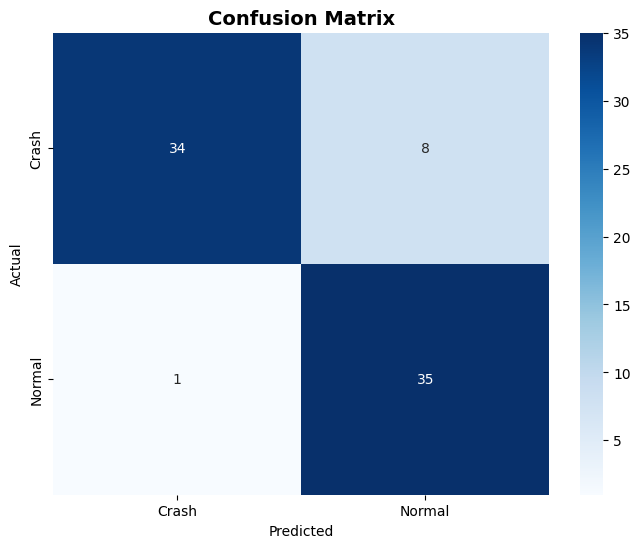

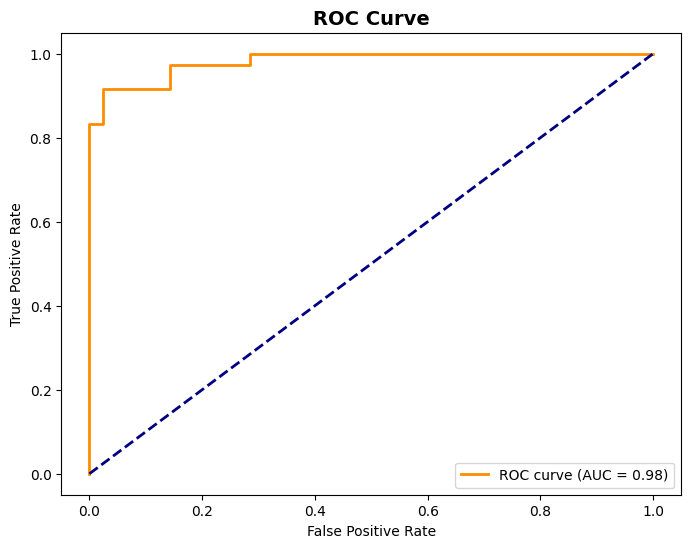

In [32]:
print("Model Evaluation")

#load best model
model = tf.keras.models.load_model('crash_model_final.h5')

#get predictions on test set
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

#get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match lengths

print(f"\nTest samples evaluated: {len(y_true)}")

#calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

#classification report
print("\nClassification Report:")
target_names = ['Crash', 'Normal'] if test_generator.class_indices['crash'] == 0 else ['Normal', 'Crash']
print(classification_report(y_true, y_pred, target_names=target_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:len(y_true)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#**Training History**

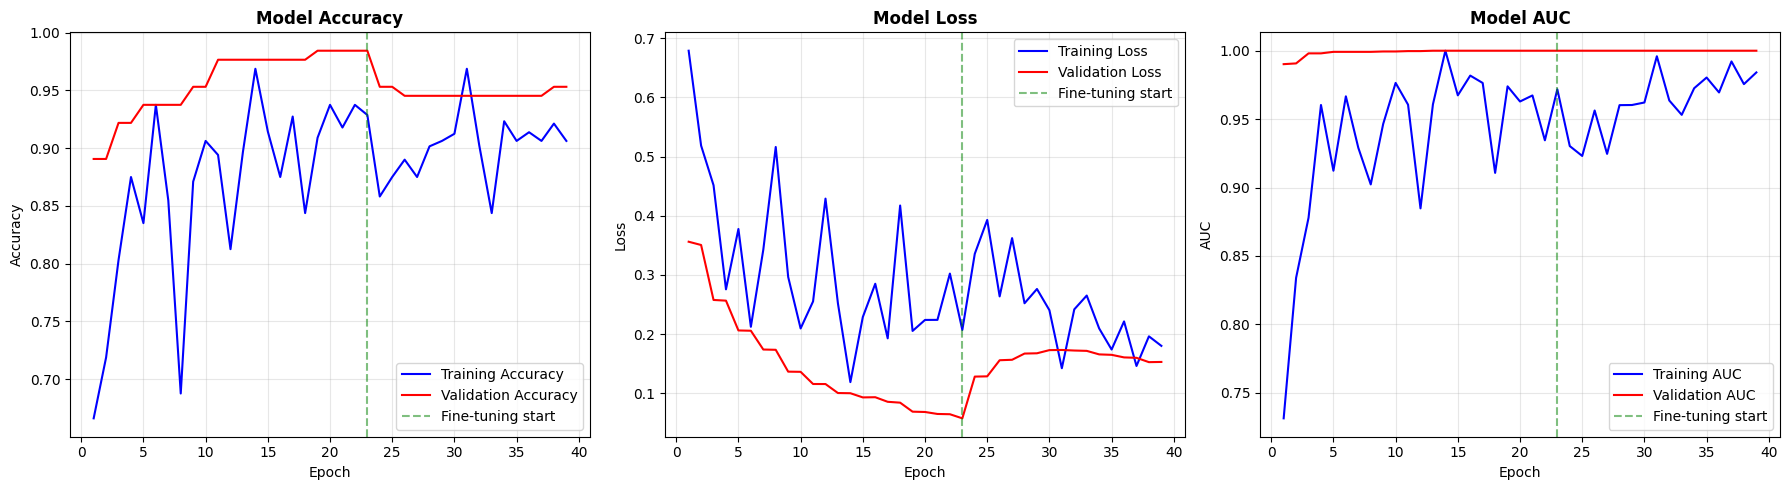

In [33]:
def plot_training(history1, history2):
    #combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    auc = history1.history['auc'] + history2.history['auc']
    val_auc = history1.history['val_auc'] + history2.history['val_auc']

    epochs = range(1, len(acc) + 1)
    phase1_epochs = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #accuracy
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    #loss
    axes[1].plot(epochs, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    #AUC
    axes[2].plot(epochs, auc, 'b-', label='Training AUC')
    axes[2].plot(epochs, val_auc, 'r-', label='Validation AUC')
    axes[2].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[2].set_title('Model AUC', fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history1, history2)

##**Export Model as a Keras and Converting to TensorFlow Lite Model for Mobile Usage**

In [34]:
from google.colab import files

print("Exporting Model")

#save Keras model
model.save('TransitLK_MSFCD_CVP_TF.h5')
print("Saved as TransitLK_MSFCD_CVP_TF.h5")

#convert to TnsorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('TransitLK_MSFCD_CVP_TF.tflite', 'wb') as f:
    f.write(tflite_model)
print("Saved as TransitLK_MSFCD_CVP_TF.tflite")

#download files
files.download('TransitLK_MSFCD_CVP_TF.h5')
files.download('TransitLK_MSFCD_CVP_TF.tflite')

Exporting Model
Saved as TransitLK_MSFCD_CVP_TF.h5
Saved artifact at '/tmp/tmpz0l40fqe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140094349550864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094349551056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468489296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094349546832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094349547024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468502352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468492944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468499280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468500048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140094468502160: TensorSpec(shap

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>